In [5]:
import torch
from tqdm import tqdm
import kaolin
import numpy as np
import matplotlib.pyplot as plt

#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

multires = 2
lr = 1e-3
iterations = 5000
save_every = 100


Using device:  NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
# MLP + Positional Encoding
class Decoder(torch.nn.Module):
    def __init__(self, input_dims = 3, internal_dims = 128, output_dims = 4, hidden = 5, multires = 2):
        super().__init__()
        self.embed_fn = None
        if multires > 0:
            embed_fn, input_ch = get_embedder(multires)
            self.embed_fn = embed_fn
            input_dims = input_ch

        net = (torch.nn.Linear(input_dims, internal_dims, bias=False), torch.nn.ReLU())
        for i in range(hidden-1):
            net = net + (torch.nn.Linear(internal_dims, internal_dims, bias=False), torch.nn.ReLU())
        net = net + (torch.nn.Linear(internal_dims, output_dims, bias=False),)
        self.net = torch.nn.Sequential(*net)

    def forward(self, p):
        if self.embed_fn is not None:
            p = self.embed_fn(p)
        out = self.net(p)
        return out

    def pre_train_sphere(self, iter):
        print ("Initialize SDF to sphere")
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(list(self.parameters()), lr=1e-4)

        for i in tqdm(range(iter)):
            p = torch.rand((1024,3), device='cuda') - 0.5
            ref_value  = torch.sqrt((p**2).sum(-1)) - 0.3
            output = self(p) # sdf 0 , deform 1-3
            loss = loss_fn(output[...,0], ref_value)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Pre-trained MLP", loss.item())

    def pre_train_circle(self, iter):
        print("Initialize SDF to circle")
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(list(self.parameters()), lr=1e-4)

        for i in tqdm(range(iter)):
            # Generate random points in the 2D plane (x, y)
            p = torch.rand((1024, 2), device='cuda') - 0.5  # x and y values in the range [-0.5, 0.5]

            # Calculate the reference value (SDF for circle)
            ref_value = torch.sqrt((p**2).sum(-1)) - 0.3  # Distance from origin (0, 0) minus the circle radius (0.3)

            # Get the network output
            output = self(p)
            
            # Compute the loss
            loss = loss_fn(output[..., 0], ref_value)
            
            # Perform backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Pre-trained MLP", loss.item())


# Positional Encoding from https://github.com/yenchenlin/nerf-pytorch/blob/1f064835d2cca26e4df2d7d130daa39a8cee1795/run_nerf_helpers.py
class Embedder:
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.create_embedding_fn()
        
    def create_embedding_fn(self):
        embed_fns = []
        d = self.kwargs['input_dims']
        out_dim = 0
        if self.kwargs['include_input']:
            embed_fns.append(lambda x : x)
            out_dim += d
            
        max_freq = self.kwargs['max_freq_log2']
        N_freqs = self.kwargs['num_freqs']
        
        if self.kwargs['log_sampling']:
            freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)
        else:
            freq_bands = torch.linspace(2.**0., 2.**max_freq, steps=N_freqs)
            
        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(x * freq))
                out_dim += d
                    
        self.embed_fns = embed_fns
        self.out_dim = out_dim
        
    def embed(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], -1)

def get_embedder(multires):
    embed_kwargs = {
                'include_input' : True,
                #'input_dims' : 3,
                'input_dims' : 2,
                'max_freq_log2' : multires-1,
                'num_freqs' : multires,
                'log_sampling' : True,
                'periodic_fns' : [torch.sin, torch.cos],
    }
    
    embedder_obj = Embedder(**embed_kwargs)
    embed = lambda x, eo=embedder_obj : eo.embed(x)
    return embed, embedder_obj.out_dim


In [ ]:
# Python code for creating a CVT
# Vassilis Vassiliades - Inria, Nancy - April 2018

import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans
import argparse

# Default values
num_centroids = 128
dimensionality = 2
num_samples = 100000
num_replicates = 1
max_iterations = 100000
tolerance = 0.00001
verbose = True

X = np.random.rand(num_samples,dimensionality)

kmeans = KMeans(
    init='k-means++', 
    n_clusters=num_centroids, 
    n_init=num_replicates, 
    #n_jobs=-1, 
    max_iter=max_iterations, 
    tol=tolerance,
    verbose=0)

kmeans.fit(X)
centroids = kmeans.cluster_centers_
centroids = np.array(centroids) * 10.0
sites = torch.from_numpy(centroids).to(device).requires_grad_(True)

Points shape:  torch.Size([391, 2])


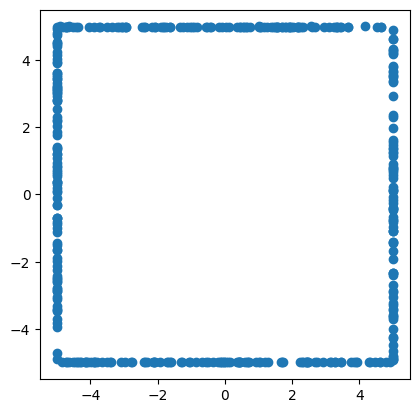

In [ ]:
# pcd_path = "./data/eabxhqb82fxu.usd"

# points = kaolin.io.usd.import_pointclouds(pcd_path)[0].points.to(device)
# if points.shape[0] > 100000:
#     idx = list(range(points.shape[0]))
#     np.random.shuffle(idx)
#     idx = torch.tensor(idx[:100000], device=points.device, dtype=torch.long)    
#     points = points[idx]

# # The reconstructed object needs to be slightly smaller than the grid to get watertight surface after MT.
# points = kaolin.ops.pointcloud.center_points(points.unsqueeze(0), normalize=True).squeeze(0) * 0.9
# #timelapse.add_pointcloud_batch(category='input', pointcloud_list=[points.cpu()], points_type = "usd_geom_points")
#---------------------------------------------------------------------------------------------------------------------
#create a 2d surface to sample points from a rectangle
points = torch.rand((100000, 2), device=device) - 0.5
surface = 0.499
#i only want the points on the edge of the rectangle
points = torch.cat([points[points[:,0] > surface], points[points[:,0] < -surface],
                    points[points[:,1] > surface], points[points[:,1] < -surface]])

points = points*10.0
print("Points shape: ", points.shape)
#plot points
plt.axes().set_aspect('equal')
plt.scatter(points[:,0].cpu(), points[:,1].cpu())
plt.show()


In [20]:
# Initialize model and create optimizer
model = Decoder(multires=multires).to(device)
model.pre_train_circle(1000)


Initialize SDF to circle


100%|██████████| 1000/1000 [00:00<00:00, 1205.09it/s]

Pre-trained MLP 1.0863743682421045e-06


In [ ]:
def loss_f(mesh_verts, mesh_faces, points, it):
    pred_points = kaolin.ops.mesh.sample_points(mesh_verts.unsqueeze(0), mesh_faces, 50000)[0][0]
    chamfer = kaolin.metrics.pointcloud.chamfer_distance(pred_points.unsqueeze(0), points.unsqueeze(0)).mean()
    #if it > iterations//2:
        #lap = laplace_regularizer_const(mesh_verts, mesh_faces)
        #return chamfer + lap * laplacian_weight
    return chamfer


def uniform_sample_edges(vertices, edges, num_points):
    # Compute edge lengths
    edge_lengths = []
    for vertex1, vertex2 in edges:
        v1 = vertices[vertex1]
        v2 = vertices[vertex2]
        length = np.linalg.norm(v2 - v1)
        edge_lengths.append(length)
    
    edge_lengths = np.array(edge_lengths)
    total_length = np.sum(edge_lengths)

    # Determine the number of points to sample per edge
    points_per_edge = (edge_lengths / total_length * num_points).astype(int)

    # Sample points along each edge
    sampled_points = []
    for i, (vertex1, vertex2) in enumerate(edges):
        v1 = vertices[vertex1]
        v2 = vertices[vertex2]
        num_edge_points = points_per_edge[i]

        # Interpolate points along the edge
        for t in np.linspace(0, 1, num_edge_points, endpoint=False):  # Exclude the endpoint to avoid duplicates
            point = (1 - t) * v1 + t * v2
            sampled_points.append(point)

    return sampled_points

# # Example usage
# num_samples = 300  # Total number of points to sample
# vertices = mesh_data["vertices"]
# edges = mesh_data["edges"]#


# # Sample points on edges
# edge_points = uniform_sample_edges(vertices, edges, num_samples)

def chamfer_distance(mesh_data, point_cloud, num_edge_samples=1000):
    # Extract vertices and edges
    vertices = mesh_data["vertices"]
    edges = mesh_data["edges"]

    # Sample points on edges
    sampled_edge_points = uniform_sample_edges(vertices, edges, num_edge_samples)

    # Convert sampled points to a torch tensor
    sampled_edge_points = torch.tensor(sampled_edge_points, dtype=torch.float32, device=point_cloud.device)

    # Compute pairwise distances
    # From point cloud to mesh edge points
    dist1 = torch.cdist(point_cloud, sampled_edge_points).min(dim=1)[0]

    # From mesh edge points to point cloud
    dist2 = torch.cdist(sampled_edge_points, point_cloud).min(dim=1)[0]

    # Chamfer distance is the sum (or average) of these distances
    chamfer_dist = torch.mean(dist1) + torch.mean(dist2)
    return chamfer_dist

# Example usage
# Assume mesh_data and point_cloud are given
chamfer_dist = chamfer_distance(mesh_data, points)
print("Chamfer Distance:", chamfer_dist.item())




In [ ]:
vars = [[p for _, p in model.named_parameters()], sites]
optimizer = torch.optim.Adam(vars, lr=lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: max(0.0, 10**(-x*0.0002))) # LR decay over time

In [ ]:
for it in range(iterations):
    pred = model(tet_verts) # predict SDF and per-vertex deformation
    sdf, deform = pred[:,0], pred[:,1:]
    verts_deformed = tet_verts + torch.tanh(deform) / grid_res # constraint deformation to avoid flipping tets
    mesh_verts, mesh_faces = kaolin.ops.conversions.marching_tetrahedra(verts_deformed.unsqueeze(0), tets, sdf.unsqueeze(0)) # running MT (batched) to extract surface mesh
    mesh_verts, mesh_faces = mesh_verts[0], mesh_faces[0]
 
    loss = loss_f(mesh_verts, mesh_faces, points, it)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if (it) % save_every == 0 or it == (iterations - 1): 
        print ('Iteration {} - loss: {}, # of mesh vertices: {}, # of mesh faces: {}'.format(it, loss, mesh_verts.shape[0], mesh_faces.shape[0]))
        # save reconstructed mesh
        #timelapse.add_mesh_batch(iteration=it+1,category='extracted_mesh',vertices_list=[mesh_verts.cpu()],faces_list=[mesh_faces.cpu()])